In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [8]:
from datetime import timedelta
from specs.parameters import system_parameters

def calc_dynamic_timelock_duration(rage_quit_support, first_seal_rage_quit_support=.01, second_seal_rage_quit_support=.1):
        dynamic_timelock_min_duration = timedelta(days=system_parameters["dynamic_timelock_min_duration"]).total_seconds()
        dynamic_timelock_max_duration = timedelta(days=system_parameters["dynamic_timelock_max_duration"]).total_seconds()

        if rage_quit_support < first_seal_rage_quit_support:
            return 0

        if rage_quit_support >= second_seal_rage_quit_support:
            return dynamic_timelock_max_duration

        time = ((rage_quit_support - first_seal_rage_quit_support)
                * (dynamic_timelock_max_duration - dynamic_timelock_min_duration)
                / (second_seal_rage_quit_support - first_seal_rage_quit_support))

        return dynamic_timelock_min_duration + time

In [28]:
def calc_one_vetoloop_duration(rage_quit_support, first_seal_rage_quit_support=.01, second_seal_rage_quit_support=.1):
    normal = 5 * 24 * 60 * 60
    signalling = calc_dynamic_timelock_duration(rage_quit_support, first_seal_rage_quit_support, second_seal_rage_quit_support)
    veto_deactivation = timedelta(days=system_parameters['veto_signalling_deactivation_max_duration']).total_seconds()
    veto_cooldown = timedelta(hours=system_parameters['veto_cooldown_duration']).total_seconds()
    return normal, signalling, veto_deactivation, veto_cooldown


In [29]:
calc_one_vetoloop_duration(0.02)

(432000, 816000.0, 259200.0, 18000.0)

In [32]:
from enum import Enum
class State(Enum):
    Normal = 1
    VetoSignalling = 2
    VetoSignallingDeactivation = 3
    VetoCooldown = 4

def get_execution_delay(rage_quit_support, first_seal_rage_quit_support=.01, second_seal_rage_quit_support=.1,
                    state=State.Normal):
    normal, signalling, veto_deactivation, veto_cooldown = calc_one_vetoloop_duration(rage_quit_support, first_seal_rage_quit_support, second_seal_rage_quit_support)
    match state:
        case State.Normal:
            return normal + signalling + veto_deactivation
        case State.VetoSignalling:
            return signalling + veto_deactivation + veto_cooldown + signalling + veto_deactivation
        case _:
            raise ValueError(f"Invalid state: {state}")

get_execution_delay(0.02, state=State.VetoSignalling)

2168400.0

**Some info.**

In VetoLoop scenario we have 4 different states: 1.Normal -> 2.VetoSignalling -> 3.VetoSignallingDeactivation -> 4.VetoCooldown -> 2.VetoSignalling -> ...

Proposal submission is possible in Normal and VetoSignalling states.

Proposal scheduling is possible in Normal state and in VetoSignalling if this proposal was submitted before current VetoSignalling window.

Proposal execution is possible in Normal and VetoCooldown states.

This means that if we submit a proposal during VetoSignalling, its execution will be delayed for a long time: we need to wait till the end of this VetoSignalling window, then VetoDeactivation, then VetoCooldown, then in the next VetoSignalling window we can schedule it, and then we need to wait till the end of this VetoSignalling window, then VetoDeactivation, finally in VetoCooldown we can execute.

If we submit a proposal during Normal state, we just need to wait VetoSignalling and VetoSignallingDeactivation till VetoCooldown for the execution.

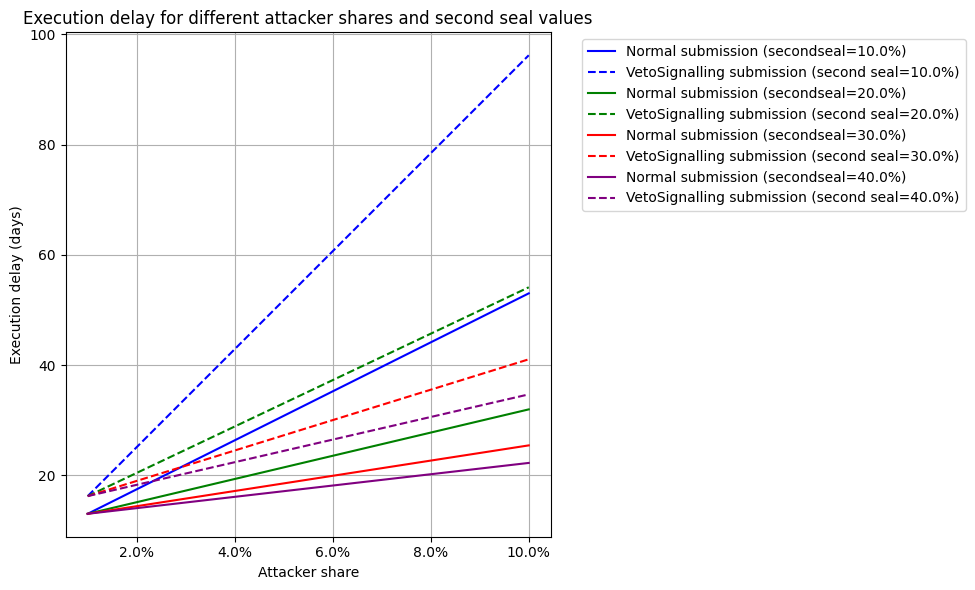

In [46]:
from matplotlib.ticker import PercentFormatter

# Define different values for second_seal_rage_quit_support
second_seal_values = [0.1, 0.2, 0.3, 0.4]
colors = ['blue', 'green', 'red', 'purple']  # Different colors for better visibility

shares = np.linspace(0.01, 0.1, 100)

plt.figure(figsize=(10, 6))  # Make the plot a bit larger

for second_seal, color in zip(second_seal_values, colors):
    # Plot for Normal state
    delays = np.array([get_execution_delay(
        x,
        state=State.Normal,
        second_seal_rage_quit_support=second_seal
    ) for x in shares])
    plt.plot(shares, delays / 60 / 60 / 24, 
             label=f'Normal submission (secondseal={second_seal*100}%)', 
             color=color, 
             linestyle='-')
    
    # Plot for VetoSignalling state
    delays = np.array([get_execution_delay(
        x,
        state=State.VetoSignalling,
        second_seal_rage_quit_support=second_seal
    ) for x in shares])
    plt.plot(shares, delays / 60 / 60 / 24, 
             label=f'VetoSignalling submission (second seal={second_seal*100}%)', 
             color=color, 
             linestyle='--')

plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Attacker share')
plt.ylabel('Execution delay (days)')
plt.title('Execution delay for different attacker shares and second seal values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

One point. If second seal is raised higher, then dynamic timelock duration is shorter for the same attacker share in escrow.

In [52]:
print('Minimal and maximal execution delays for a proposal submitted in Normal state:',
      f'{int(get_execution_delay(0.01, state=State.Normal, second_seal_rage_quit_support=0.1) / 60 / 60 / 24)} days,',
      f'{int(get_execution_delay(0.1, state=State.Normal, second_seal_rage_quit_support=0.1) / 60 / 60 / 24)} days')
print('Minimal and maximal execution delays for a proposal submitted in VetoSignalling state:',
      f'{int(get_execution_delay(0.01, state=State.VetoSignalling, second_seal_rage_quit_support=0.1) / 60 / 60 / 24)} days,',
      f'{int(get_execution_delay(0.1, state=State.VetoSignalling, second_seal_rage_quit_support=0.1) / 60 / 60 / 24)} days')


Minimal and maximal execution delays for a proposal submitted in Normal state: 13 days, 53 days
Minimal and maximal execution delays for a proposal submitted in VetoSignalling state: 16 days, 96 days
